# Bag of pattern feature

Linear time method for classify time series using 1-NN approach. The method consist on generate all the sub-sequences of length $S$ from the timeseries, transforming each sub-sequence into a SAX word, generating a Bag-of-Patter representation.  

For irregular time series support the following modifications are made:

1. sub-sequence length will be defined based on time window instead of number of samples
2. sub-sequences with empty segments will be represented with special character on the SAX word.


## Step by step execution

Bag-of-Pattern features is a secuential process composed of several steps. Here we will show them based on the implemented source code using a **small dataset of regular time series**

In [1]:
import sys
import os
from collections import defaultdict
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname("./Untitled.ipynb"), '..')))
import numpy as np
from src.bopf.bopf import BagOfPatternFeature
import matplotlib.pyplot as plt
%matplotlib inline

1. instanciate the main class

In [2]:
# special_character set to FALSE when using regular time series
bopf = BagOfPatternFeature(special_character=False)

2. load the dataset. In this case we will use Car dataset from UCR Archive which has 60 train samples and 60 test samples

In [3]:
%%time
# path windows
path = "D:/tesis/UCRArchive_2018/FaceFour/FaceFour_TRAIN.tsv"
bopf.load_dataset(path, fmt="file")
print("train size:", bopf.m, "Ts len:", len(bopf.dataset[0]))

train size: 24 Ts len: 350
Wall time: 4.01 ms


3. compute the CUMSUM matrix, needed for the linear time PAA computation.

In [4]:
%%time
bopf.cumsum()

Wall time: 13 ms


4. get the bag-of-pattern representation for each time series. Input parameters are:

    - Word length (wd): the number of letter within each word
    - Sub-sequence width (wl): the size of each sub-sequence, input is a fraction ($[0, 1]$) of the whole time series width 

In [5]:
%%time
wd = 5 
wl = 0.325
bopf.bop(wd, wl)

TOTAL DE SEGMENTOS VACIOS:  0
Wall time: 259 ms


5. adjust the labels, getting the counts of time series on each class and an index array for each time series which lead to its label

In [6]:
%%time
bopf.adjust_label_set()

Wall time: 0 ns


6. Perform ANOVA F Test for discriminating the best features of the bag-of-pattern representation

In [7]:
%%time
bopf.anova()

Wall time: 62.8 ms


7. drop all features with ANOVA F value 0 and sort the rest in decreasing order

In [8]:
%%time
bopf.anova_sort()
print("bopf features will be reduced from %d to %d" % (bopf.bopsize, bopf.fea_num))

bopf features will be reduced from 1024 to 244
Wall time: 0 ns


8. sort and trim the bag-of-pattern representation matrix of the whole dataset according tho the anova_sort

In [9]:
%%time
bopf.sort_trim_arr()

Wall time: 4.02 ms


9. cross validate the accuracy of classification under leave-one-out method for the reduced bag-of-pattern representation, testing different combination of the top features. The cross validation is made under two different values:
    - cross validation using class centroids for classification
    - cross validation using class TF-IDF weights for classification

In [35]:
%%time
# cross validation using centroids
bopf.crossVL(verbose=False)
print("best accuracy of CV: ", bopf.best_score, ", using the top", bopf.best_idx, "features according to ANOVA F")

best accuracy of CV:  1.0 , using the top 208 features according to ANOVA F
Wall time: 47.9 ms


In [36]:
%%time
# cross validation using tf-idf
bopf.crossVL2()
print("best accuracy of CV2: ", bopf.best2_score, ", using the top", bopf.best2_idx, "features according to ANOVA F")

best accuracy of CV2:  1.0 , using the top 244 features according to ANOVA F
Wall time: 114 ms


10. classify a test set using the best configuration for centroids or tf-idf

In [11]:
from src.bopf.classifier import classify, classify2
from src.utils import sort_trim_arr

In [37]:
# load the test set
bopf_t = BagOfPatternFeature(special_character=False)
path_t = "D:/tesis/UCRArchive_2018/FaceFour/FaceFour_TEST.tsv"
bopf_t.load_dataset(path_t, fmt="file")

# compute CUMSUM matrix for test set
bopf_t.cumsum()

# compute bag-of-pattern representation for test set
bopf_t.bop(wd, wl)

# sort and trim the bag-of-pattern representation based on the centroid best configuration
test_bop_sort = sort_trim_arr(bopf_t.train_bop, bopf.sort_index[:bopf.best_idx], 
                                  bopf_t.m, bopf.best_idx)
# classify to get predicted labels
predicted_label = classify(test_bop_sort, bopf.crossL[:bopf. c*bopf.best_idx], bopf.tlabel, 
                               bopf_t.m, bopf.c, bopf.best_idx)

# get real labels of test set
real_label = np.array(bopf_t.labels)

# compute accuracy
count = 0
for i in range(len(real_label)):
    if predicted_label[i] == real_label[i]:
        count += 1

acc = count / bopf_t.m
print("accuracy of classify using wd:", wd, ", wl:", wl, ", and best config for centroids is:", acc)

### repeat for tf-idf

# sort and trim the bag-of-pattern representation based on the centroid best configuration
test_bop_sort2 = sort_trim_arr(bopf_t.train_bop, bopf.sort_index[:bopf.best2_idx], 
                                  bopf_t.m, bopf.best2_idx)
# classify to get predicted labels
predicted_label2 = classify2(test_bop_sort2, bopf.crossL2[:bopf.c*bopf.best2_idx], bopf.tlabel, 
                               bopf_t.m, bopf.c, bopf.best2_idx)

# compute accuracy
count = 0
for i in range(len(real_label)):
    if predicted_label2[i] == real_label[i]:
        count += 1
        
acc2 = count / len(real_label)
print("accuracy of classify using wd:", wd, ", wl:", wl, ", and best config for tf-idf is:", acc2)

TOTAL DE SEGMENTOS VACIOS:  0
accuracy of classify using wd: 5 , wl: 0.325 , and best config for centroids is: 0.6704545454545454
accuracy of classify using wd: 5 , wl: 0.325 , and best config for tf-idf is: 0.25


## Looking for best parameters

for best accuracy the combination parameter (wd, wl) has to be improved. In order to achive that, a number of word length ans sub-sequence width are defined and every combination is testes choosing the bests based on cross validation results.

On paper they propose:

    - wd: {3, 4, 5, 6, 7}
    - wl: {0.025, 0.05, 0.075, ..., 1}
    
and we will execute our code over UCR datasets used on the paper, looking for a resulting accuracy simmilar to the ones presented on the paper

In [38]:
wd_arr = [3, 4, 5, 6, 7]
step = 0.05
wl_arr = np.round((np.arange(int(1/step))+1)*step, 2)


def main_test_ucr_p1(train_file, test_file, wd_arr, wl_arr):
    wd_num = len(wd_arr)
    wl_num = len(wl_arr)
    
    bopf = BagOfPatternFeature(special_character=False)
    bopf.load_dataset(train_file, fmt="file")
    bopf.cumsum()
    
    bopf_t = BagOfPatternFeature(special_character=False)
    bopf_t.load_dataset(test_file, fmt="file")
    bopf_t.cumsum()
    
    output_dict = defaultdict(list)
    
    for i in range(wd_num):
        wd = wd_arr[i]
        for j in range(wl_num):
            wl = wl_arr[j]
            print("wd: {}".format(wd) + ", wl: {}".format(wl), end="\r")
            bopf.bop(wd, wl, verbose=False)
            bopf.adjust_label_set()
            bopf.anova(verbose=False)
            bopf.anova_sort()
            bopf.sort_trim_arr(verbose=False)
            
            bopf.crossVL(verbose=False)
            output_dict["bop_features"].append(bopf.crossL[:bopf.c*bopf.best_idx])
            output_dict["bop_fea_num"].append(bopf.best_idx)
            output_dict["bop_cv_acc"].append(bopf.best_score)
            output_dict["bop_feature_index"].append(bopf.sort_index[:bopf.best_idx])
            
            bopf.crossVL2()
            output_dict["bop_features2"].append(bopf.crossL2[:bopf.c*bopf.best2_idx])
            output_dict["bop_fea_num2"].append(bopf.best2_idx)
            output_dict["bop_cv_acc2"].append(bopf.best2_score)
            output_dict["bop_feature_index2"].append(bopf.sort_index[:bopf.best2_idx])
            
            output_dict["bop_wd"].append(wd)
            output_dict["bop_wl"].append(wl)
            
    print("wd: {}".format(wd) + ", wl: {0:.2f}".format(wl))
    return bopf, bopf_t, output_dict
    
def main_test_ucr_p2(bopf, bopf_t, output_dict, top_n):
    index1 = np.argsort(output_dict["bop_cv_acc"])[::-1]
    index2 = np.argsort(output_dict["bop_cv_acc2"])[::-1]

#     avg_acc_sum = 0
#     avg_acc_sum2 = 0
#     for i in range(top_n):
#         avg_acc_sum += output_dict["bop_cv_acc"][index1[i]]
#         avg_acc_sum2 += output_dict["bop_cv_acc2"][index2[i]]

#     avg_acc = avg_acc_sum / top_n
#     avg_acc2 = avg_acc_sum2 / top_n
#     if avg_acc > avg_acc2:
        # classify using centroid
    best_centroid = -1
    best_tf_idf = -1
    rbest_centroid = -np.inf
    rbest_tf_idf = -np.inf
    for i in range(top_n):
        print(i, end="\r")
        s_index = index1[i]
        wd = output_dict["bop_wd"][s_index]
        wl = output_dict["bop_wl"][s_index]
        bopf_t.bop(wd, wl, verbose=False)
        test_bop_sort = sort_trim_arr(bopf_t.train_bop, output_dict["bop_feature_index"][s_index], 
                                  bopf_t.m, output_dict["bop_fea_num"][s_index])
        predicted_label = classify(test_bop_sort, output_dict["bop_features"][s_index], bopf.tlabel, 
                               bopf_t.m, bopf.c, output_dict["bop_fea_num"][s_index])
        real_label = np.array(bopf_t.labels)
        count = 0
        for j in range(len(real_label)):
            if predicted_label[j] == real_label[j]:
                count += 1
        acc = count / len(real_label)
        if acc > rbest_centroid:
            rbest_centroid = acc
            best_centroid = i
    s_index = index1[best_centroid]
    print("classify with best centroid and wd:", output_dict["bop_wd"][s_index], 
          ", wl:", output_dict["bop_wl"][s_index], 
          "-> cv_acc:", round(output_dict["bop_cv_acc"][s_index], 3),
          ", acc:", round(rbest_centroid, 3))
    
#     else:
    # classify using tf-idf
    # classify using centroid
    for i in range(top_n):
        print(i, end="\r")
        s_index = index2[i]
        wd = output_dict["bop_wd"][s_index]
        wl = output_dict["bop_wl"][s_index]
        bopf_t.bop(wd, wl, verbose=False)
        test_bop_sort = sort_trim_arr(bopf_t.train_bop, output_dict["bop_feature_index2"][s_index], 
                              bopf_t.m, output_dict["bop_fea_num2"][s_index])
        predicted_label = classify2(test_bop_sort, output_dict["bop_features2"][s_index], bopf.tlabel, 
                           bopf_t.m, bopf.c, output_dict["bop_fea_num2"][s_index])
        real_label = np.array(bopf_t.labels)
        count = 0
        for j in range(len(real_label)):
            if predicted_label[j] == real_label[j]:
                count += 1
        acc = count / len(real_label)
        if acc > rbest_tf_idf:
            rbest_tf_idf = acc
            best_tf_idf = i
            
    s_index = index2[best_tf_idf]
    print("classify with best tf-idf and wd:", output_dict["bop_wd"][s_index], 
          ", wl:", output_dict["bop_wl"][s_index], 
          "-> cv_acc:", round(output_dict["bop_cv_acc2"][s_index], 3),
          ", acc:", round(rbest_tf_idf, 3))
    

## Control tests on regular datasets

we will do some sanity checks by comparing accuracy of our implementation with the paper's results for the same datasets. Dataset used will be:

- FaceFour
- BeetleFly
- Car
- Haptics

all of them can be founde on [UCR Archive](https://www.cs.ucr.edu/~eamonn/time_series_data_2018/)

### FaceFour dataset

In [13]:
%%time
train_file = "D:/tesis/UCRArchive_2018/FaceFour/FaceFour_TRAIN.tsv"
test_file = "D:/tesis/UCRArchive_2018/FaceFour/FaceFour_TEST.tsv"
wd_arr = [3, 4, 5, 6, 7]
step = 0.025
wl_arr = np.round((np.arange(int(1/step))+1)*step, 3)
bopf3, bopf_t3, output_dict3 = main_test_ucr_p1(train_file, test_file, wd_arr, wl_arr)

D:\tesis\tesis\src\bopf\bopf.py:226: RuntimeWarning: invalid value encountered in sqrt
  sigmax = np.sqrt(round(sumx2 / (seq_j-seq_i), 15) - round(meanx * meanx, 15))
D:\tesis\tesis\src\bopf\bopf.py:244: RuntimeWarning: divide by zero encountered in double_scalars
  paa = (avgsub - meanx) / sigmax


wd: 7, wl: 1.005
Wall time: 2min 11s


In [21]:
top_n = 50
main_test_ucr_p2(bopf3, bopf_t3, output_dict3, top_n)

classify with best centroid and wd: 4 , wl: 0.425 -> cv_acc: 1.0 , acc: 0.955


D:\tesis\tesis\src\bopf\bopf.py:191: RuntimeWarning: invalid value encountered in double_scalars
  paa = (avgsub - meanx) / sigmax


classify with best tf-idf and wd: 4 , wl: 0.475 -> cv_acc: 1.0 , acc: 0.852


### BeetleFly dataset

In [22]:
%%time
train_file = "D:/tesis/UCRArchive_2018/BeetleFly/BeetleFly_TRAIN.tsv"
test_file = "D:/tesis/UCRArchive_2018/BeetleFly/BeetleFly_TEST.tsv"
wd_arr = [3, 4, 5, 6, 7]
step = 0.025
wl_arr = np.round((np.arange(int(1/step))+1)*step, 3)
bopf0, bopf_t0, output_dict0 = main_test_ucr_p1(train_file, test_file, wd_arr, wl_arr)

wd: 7, wl: 1.005
Wall time: 2min 3s


In [23]:
%%time
top_n = 50
main_test_ucr_p2(bopf0, bopf_t0, output_dict0, top_n)

classify with best centroid and wd: 5 , wl: 0.175 -> cv_acc: 1.0 , acc: 0.85


D:\tesis\tesis\src\bopf\classifier.py:55: RuntimeWarning: invalid value encountered in double_scalars
  r = r1 * r1 / (r2 * r3)


classify with best tf-idf and wd: 5 , wl: 0.8 -> cv_acc: 1.0 , acc: 0.6
Wall time: 35 s


### Car dataset

In [24]:
%%time
train_file = "D:/tesis/UCRArchive_2018/Car/Car_TRAIN.tsv"
test_file = "D:/tesis/UCRArchive_2018/Car/Car_TEST.tsv"
wd_arr = [3, 4, 5, 6, 7]
step = 0.025
wl_arr = np.round((np.arange(int(1/step))+1)*step, 3)
bopf1, bopf_t1, output_dict1 = main_test_ucr_p1(train_file, test_file, wd_arr, wl_arr)

wd: 7, wl: 1.005
Wall time: 6min 15s


In [25]:
top_n = 50
main_test_ucr_p2(bopf1, bopf_t1, output_dict1, top_n)

classify with best centroid and wd: 7 , wl: 0.3 -> cv_acc: 0.917 , acc: 0.683
classify with best tf-idf and wd: 6 , wl: 0.85 -> cv_acc: 0.833 , acc: 0.483


### Haptics dataset

In [27]:
%%time
train_file = "D:/tesis/UCRArchive_2018/Haptics/Haptics_TRAIN.tsv"
test_file = "D:/tesis/UCRArchive_2018/Haptics/Haptics_TEST.tsv"
wd_arr = [3, 4, 5, 6, 7]
step = 0.025
wl_arr = np.round((np.arange(int(1/step))+1)*step, 3)
bopf4, bopf_t4, output_dict4 = main_test_ucr_p1(train_file, test_file, wd_arr, wl_arr)

wd: 7, wl: 1.005
Wall time: 36min 52s


In [29]:
%%time
top_n = 50
main_test_ucr_p2(bopf4, bopf_t4, output_dict4, top_n)

classify with best centroid and wd: 5 , wl: 0.775 -> cv_acc: 0.555 , acc: 0.36
classify with best tf-idf and wd: 7 , wl: 0.45 -> cv_acc: 0.723 , acc: 0.224
Wall time: 33min 45s


### Comparing paper vs our results

| Dataset | Accuracy paper | Accuracy us |
| :-: | :-: | :-: |
| FaceFour | 1 | 0.96 |
| BeetleFly | 0.8 | 0.85|
| Car | 0.73 | 0.68 |
| Haptics | 0.42 | 0.36|

At most 6% difference is probably due to difference in sorting algorithms. To check this problem should use stable_sort on bot my python implementation and the author's implementation in c++

## Application to irregular time series

### Simple case execution

In [4]:
bopf = BagOfPatternFeature(special_character=True)
path = "D:/tesis/tesis/data/plasticc_sub_dataset/"
bopf.load_dataset(path, fmt="npy", set_type="train", n1=100, n2=100, c=4)
print("train size:", bopf.m)
bopf.cumsum()
wd = 7 
wl = 0.325
print("computing BOP...", end="")
bopf.bop(wd, wl, verbose=False)
print("DONE")
print("adjusting labels...", end="")
bopf.adjust_label_set()
print("DONE")
print("computing ANOVA...", end="")
bopf.anova(verbose=False)
print("DONE")
print("sorting ANOVA values...", end="")
bopf.anova_sort()
print("DONE")
print("sort BOP representation...", end="")
bopf.sort_trim_arr(verbose=False)
print("DONE")
bopf.crossVL(verbose=False)
print("best accuracy of CV: ", bopf.best_score, ", using the top", bopf.best_idx, "features according to ANOVA F")
bopf.crossVL2()
print("best accuracy of CV2: ", bopf.best2_score, ", using the top", bopf.best2_idx, "features according to ANOVA F")


# load the test set
bopf_t = BagOfPatternFeature(special_character=True)
bopf_t.load_dataset(path, fmt="npy", set_type="test", n1=100, n2=100, c=4)

# compute CUMSUM matrix for test set
bopf_t.cumsum()

# compute bag-of-pattern representation for test set
bopf_t.bop(wd, wl, verbose=False)

# sort and trim the bag-of-pattern representation based on the centroid best configuration
test_bop_sort = sort_trim_arr(bopf_t.train_bop, bopf.sort_index[:bopf.best_idx], 
                                  bopf_t.m, bopf.best_idx)
# classify to get predicted labels
predicted_label = classify(test_bop_sort, bopf.crossL[:bopf. c*bopf.best_idx], bopf.tlabel, 
                               bopf_t.m, bopf.c, bopf.best_idx)

# get real labels of test set
real_label = np.array(bopf_t.labels)

# compute accuracy
count = 0
for i in range(len(real_label)):
    if predicted_label[i] == real_label[i]:
        count += 1

acc = count / bopf_t.m
print("accuracy of classify using wd:", wd, ", wl:", wl, ", and best config for centroids is:", acc)

### repeat for tf-idf

# sort and trim the bag-of-pattern representation based on the centroid best configuration
test_bop_sort2 = sort_trim_arr(bopf_t.train_bop, bopf.sort_index[:bopf.best2_idx], 
                                  bopf_t.m, bopf.best2_idx)
# classify to get predicted labels
predicted_label2 = classify2(test_bop_sort2, bopf.crossL2[:bopf.c*bopf.best2_idx], bopf.tlabel, 
                               bopf_t.m, bopf.c, bopf.best2_idx)

# compute accuracy
count = 0
for i in range(len(real_label)):
    if predicted_label2[i] == real_label[i]:
        count += 1
        
acc2 = count / len(real_label)
print("accuracy of classify using wd:", wd, ", wl:", wl, ", and best config for tf-idf is:", acc2)

train size: 100
computing BOP...DONE
adjusting labels...DONE
computing ANOVA...DONE
sorting ANOVA values...DONE
sort BOP representation...DONE
best accuracy of CV:  0.53 , using the top 3 features according to ANOVA F
best accuracy of CV2:  0.97 , using the top 411 features according to ANOVA F
accuracy of classify using wd: 7 , wl: 0.325 , and best config for centroids is: 0.37
accuracy of classify using wd: 7 , wl: 0.325 , and best config for tf-idf is: 0.19


## Experimental evaluation on sub-datasets from PLaSTiCC

for faster execution the experiments where performed on terminal using multiprocessing and here we will show the results

| train set | test set | N classes | best acc BOPF | acc DTW | acc TWED |
| :-: | :-: | :-: | :-: | :-: | :-: |
| 10 | 10 | 2 | 0.8 | 0.8 | 0.4 |
| 100 | 100 | 4 | 0.46 | 0.31 | 0.17 |
| 500 | 500 | 4 | 0.47 | 0.32 | 0.43 |
| 1000 | 1000 | 10 | 0.32 | 0.25 | 0.32 |

unfortunately, BOPF was executed on a different machine than brute force DTW and TWE so the train time and test time cannot be compared.

Note: The test part wasn't executed using multiprocessing, only the train part was executed using multiprocessing on a machine with 6 cores

| 200 | 100 | 4 | 615.00 | 42.51 | 0.49 | 0.35 | 0.51 |
| 1000 | 500 | 4| 2362.54 | 470.91 | 0.47 | 0.35 | -- |

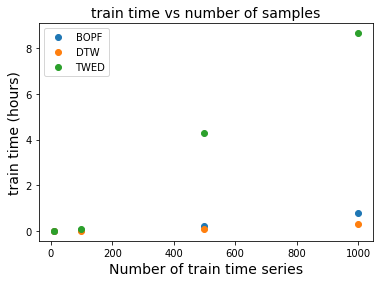

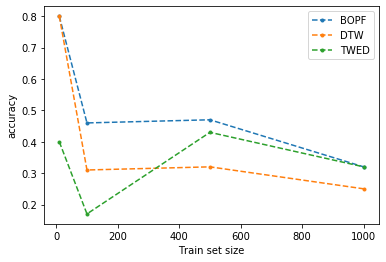

In [15]:
train_time = [37.15, 181.54, 1109.84, 3826.74]
dtw_dist_time = [0.123, 6.227, 253.757, 1047.021]
twed_dist_time = [2.1, 326.245, 15460.57, 31179.298]
train_set = [10, 100, 500, 1000]

bopf_acc = [0.8, 0.46, 0.47, 0.32]
dtw_acc = [0.8, 0.31, 0.32, 0.25]
twed_acc = [0.4, 0.17, 0.43, 0.32]

fig = plt.figure()
plt.plot(train_set, np.array(train_time) * (6/8) / 60 / 60, 'o', label="BOPF")
plt.plot(train_set, np.array(dtw_dist_time) / 60 / 60, 'o', label="DTW")
plt.plot(train_set, np.array(twed_dist_time) / 60 / 60, 'o', label="TWED")
plt.xlabel("Number of train time series", fontsize=14)
plt.ylabel("train time (hours)", fontsize=14)
plt.title("train time vs number of samples", fontsize=14)
plt.legend()

fig = plt.figure()
plt.plot(train_set, bopf_acc, '--.', label="BOPF")
plt.plot(train_set, dtw_acc, '--.', label="DTW")
plt.plot(train_set, twed_acc, '--.', label="TWED")
plt.xlabel("Train set size")
plt.ylabel("accuracy")
plt.legend()

### TO-DO on datasets

1. create sub-datasets of same train/test ratio and same number of classes but changing the number of samples
2. create sub-datasets of same number of samples and classes but different train/test ratio
3. execute brute force DTW, brute force TWED and BOPF on same machine for time test